In [382]:
import os
import h5py
import numpy as np
import pandas as pd
import geopandas as gp
from shapely.geometry import Point
import geoviews as gv
from geoviews import opts, tile_sources as gvts

In [383]:
inDir = os.getcwd() + os.sep
inDir

'C:\\Users\\beast\\'

In [384]:
gediFiles = [g for g in os.listdir() if g.startswith('GEDI02_B') and g.endswith('.h5')]  # List all GEDI L2B .h5 files in inDir
gediFiles

['GEDI02_B_2019170155833_O02932_T02267_02_001_01.h5',
 'GEDI02_B_2020221195419_O09386_T03109_02_001_01.h5']

In [385]:
L2B = 'GEDI02_B_2020221195419_O09386_T03109_02_001_01.h5'
L2B

'GEDI02_B_2020221195419_O09386_T03109_02_001_01.h5'

In [386]:
gediL2B = h5py.File(L2B, 'r')  # Read file using h5py

In [387]:
list(gediL2B.keys())

['BEAM0000',
 'BEAM0001',
 'BEAM0010',
 'BEAM0011',
 'BEAM0101',
 'BEAM0110',
 'BEAM1000',
 'BEAM1011',
 'METADATA']

In [388]:
list(gediL2B['METADATA'])

['DatasetIdentification']

In [389]:
for g in gediL2B['METADATA']['DatasetIdentification'].attrs: print(g)

PGEVersion
VersionID
abstract
characterSet
creationDate
credit
fileName
language
originatorOrganizationName
purpose
shortName
spatialRepresentationType
status
topicCategory
uuid


In [390]:
print(gediL2B['METADATA']['DatasetIdentification'].attrs['purpose'])

The purpose of the L2B dataset is to extract biophysical metrics from each GEDI waveform. These metrics are based on the directional gap probability profile derived from the L1B waveform and include canopy cover, Plant Area Index (PAI), Plant Area Volume Density (PAVD) and Foliage Height Diversity (FHD).


In [391]:
beamNames = [g for g in gediL2B.keys() if g.startswith('BEAM')]
beamNames

['BEAM0000',
 'BEAM0001',
 'BEAM0010',
 'BEAM0011',
 'BEAM0101',
 'BEAM0110',
 'BEAM1000',
 'BEAM1011']

In [392]:
for g in gediL2B['BEAM0000'].attrs: print(g)

description
wp-l2-l2b_githash
wp-l2-l2b_version


In [393]:
for b in beamNames:
    print(f"{b} is a {gediL2B[b].attrs['description']}")

BEAM0000 is a Coverage beam
BEAM0001 is a Coverage beam
BEAM0010 is a Coverage beam
BEAM0011 is a Coverage beam
BEAM0101 is a Full power beam
BEAM0110 is a Full power beam
BEAM1000 is a Full power beam
BEAM1011 is a Full power beam


In [394]:
beamNames = ['BEAM0110']

In [395]:
gediL2B_objs = []
gediL2B.visit(gediL2B_objs.append)                                           # Retrieve list of datasets
gediSDS = [o for o in gediL2B_objs if isinstance(gediL2B[o], h5py.Dataset)]  # Search for relevant SDS inside data file
[i for i in gediSDS if beamNames[0] in i][0:10]                              # Print the first 10 datasets for selected beam

['BEAM0110/algorithmrun_flag',
 'BEAM0110/ancillary/dz',
 'BEAM0110/ancillary/l2a_alg_count',
 'BEAM0110/ancillary/maxheight_cuttoff',
 'BEAM0110/ancillary/rg_eg_constraint_center_buffer',
 'BEAM0110/ancillary/rg_eg_mpfit_max_func_evals',
 'BEAM0110/ancillary/rg_eg_mpfit_maxiters',
 'BEAM0110/ancillary/rg_eg_mpfit_tolerance',
 'BEAM0110/ancillary/signal_search_buff',
 'BEAM0110/ancillary/tx_noise_stddev_multiplier']

In [396]:
lonSample, latSample, shotSample, qualitySample, beamSample = [], [], [], [], []  # Set up lists to store data

# Open the SDS
lats = gediL2B[f'{beamNames[0]}/geolocation/lat_lowestmode'][()]
lons = gediL2B[f'{beamNames[0]}/geolocation/lon_lowestmode'][()]
shots = gediL2B[f'{beamNames[0]}/geolocation/shot_number'][()]
quality = gediL2B[f'{beamNames[0]}/l2b_quality_flag'][()]

# Take every 100th shot and append to list
for i in range(len(shots)):
    if i % 100 == 0:
        shotSample.append(str(shots[i]))
        lonSample.append(lons[i])
        latSample.append(lats[i])
        qualitySample.append(quality[i])
        beamSample.append(beamNames[0])

# Write all of the sample shots to a dataframe
latslons = pd.DataFrame({'Beam': beamSample, 'Shot Number': shotSample, 'Longitude': lonSample, 'Latitude': latSample,
                         'Quality Flag': qualitySample})
latslons

,Beam,Shot Number,Longitude,Latitude,Quality Flag
0,BEAM0110,93860607000000001,101.983568,-51.802219,0
1,BEAM0110,93860617000000101,102.024731,-51.802104,0
2,BEAM0110,93860603200000201,102.067493,-51.801977,0
3,BEAM0110,93860613200000301,102.108629,-51.801822,0
4,BEAM0110,93860623200000401,102.149784,-51.801667,0
...,...,...,...,...,...
9879,BEAM0110,93860614300987901,78.250625,-51.804415,0
9880,BEAM0110,93860600100988001,78.291840,-51.804378,0
9881,BEAM0110,93860610500988101,78.334625,-51.804313,0
9882,BEAM0110,93860620500988201,78.375760,-51.804241,0


In [397]:
del beamSample, quality, qualitySample, gediL2B_objs, latSample, lats, lonSample, lons, shotSample, shots

In [398]:
latslons['geometry'] = latslons.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)

In [399]:
# Convert to a Geodataframe
latslons = gp.GeoDataFrame(latslons)
latslons = latslons.drop(columns=['Latitude','Longitude'])
latslons['geometry']

0       POINT (101.98357 -51.80222)
1       POINT (102.02473 -51.80210)
2       POINT (102.06749 -51.80198)
3       POINT (102.10863 -51.80182)
4       POINT (102.14978 -51.80167)
                   ...             
9879     POINT (78.25062 -51.80442)
9880     POINT (78.29184 -51.80438)
9881     POINT (78.33463 -51.80431)
9882     POINT (78.37576 -51.80424)
9883     POINT (78.41696 -51.80413)
Name: geometry, Length: 9884, dtype: geometry

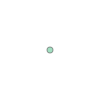

In [400]:
latslons['geometry'][0]

In [401]:
def pointVisual(features, vdims):
    return (gvts.EsriImagery * gv.Points(features, vdims=vdims).options(tools=['hover'], height=500, width=900, size=5,
                                                                        color='yellow', fontsize={'xticks': 10, 'yticks': 10,
                                                                                                  'xlabel':16, 'ylabel': 16}))

In [402]:
SouthAfrica = gp.GeoDataFrame.from_file('SouthAfrica.json')  # Import geojson as GeoDataFrame

In [403]:
SouthAfrica

,scalerank,featurecla,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,...,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,filename,geometry
0,1,Admin-0 country,2,South Africa,ZAF,0,2,Sovereign country,South Africa,ZAF,...,Africa,Southern Africa,Sub-Saharan Africa,12,12,5,-99,1,ZAF.geojson,"MULTIPOLYGON (((37.85693 -46.94424, 37.81396 -..."


In [404]:
# Create a list of geodataframe columns to be included as attributes in the output map
vdims = []
for f in latslons:
    if f not in ['geometry']:
        vdims.append(f)
vdims

['Beam', 'Shot Number', 'Quality Flag']

In [405]:
gv.Polygons(SouthAfrica['geometry']).opts(line_color='red', color=None) * pointVisual(latslons, vdims = vdims)

:Overlay
   .Polygons.I :Polygons   [Longitude,Latitude]
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Points.I   :Points   [Longitude,Latitude]   (Beam,Shot Number,Quality Flag)

In [406]:
print(f"Quality Flag: {gediL2B[b]['l2b_quality_flag'].attrs['description']}")

Quality Flag: Flag simpilfying selection of most useful data for Level 2B


In [407]:
beamNames = [g for g in gediL2B.keys() if g.startswith('BEAM')]
beamNames

['BEAM0000',
 'BEAM0001',
 'BEAM0010',
 'BEAM0011',
 'BEAM0101',
 'BEAM0110',
 'BEAM1000',
 'BEAM1011']

In [408]:
shotNum, dem, zElevation, zHigh, zLat, zLon, canopyHeight, quality, degrade, sensitivity, pai, beamI = ([] for i in range(12))

In [409]:
for b in beamNames:
    [shotNum.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/shot_number') and b in g][0]][()]]
    [dem.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/digital_elevation_model') and b in g][0]][()]]
    [zElevation.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/elev_lowestmode') and b in g][0]][()]]  
    [zHigh.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/elev_highestreturn') and b in g][0]][()]]  
    [zLat.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/lat_lowestmode') and b in g][0]][()]]  
    [zLon.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/lon_lowestmode') and b in g][0]][()]]  
    [canopyHeight.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/rh100') and b in g][0]][()]]  
    [quality.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/l2b_quality_flag') and b in g][0]][()]]  
    [degrade.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/degrade_flag') and b in g][0]][()]]  
    [sensitivity.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/sensitivity') and b in g][0]][()]]  
    [beamI.append(h) for h in [b] * len(gediL2B[[g for g in gediSDS if g.endswith('/shot_number') and b in g][0]][()])]  
    [pai.append(h) for h in gediL2B[f'{b}/pai'][()]]    

In [410]:
allDF = pd.DataFrame({'Shot Number': shotNum, 'Beam': beamI, 'Latitude': zLat, 'Longitude': zLon, 'Tandem-X DEM': dem,
                      'Elevation (m)': zElevation, 'Canopy Elevation (m)': zHigh, 'Canopy Height (rh100)': canopyHeight,
                      'Quality Flag': quality, 'Plant Area Index': pai,'Degrade Flag': degrade, 'Sensitivity': sensitivity})

In [411]:
del beamI, canopyHeight, degrade, dem, gediSDS, pai, quality, sensitivity, zElevation, zHigh, zLat, zLon, shotNum

In [412]:
len(allDF)

3505255

In [413]:
CRFcoord=(18.075944,-34.714464,25.527152,-32.518325) 

In [414]:
minLon, minLat, maxLon, maxLat = CRFcoord

In [415]:
allDF = allDF.where(allDF['Latitude'] > minLat)
allDF = allDF.where(allDF['Latitude'] < maxLat)
allDF = allDF.where(allDF['Longitude'] > minLon)
allDF = allDF.where(allDF['Longitude'] < maxLon)

In [416]:
allDF = allDF.dropna()

In [417]:
len(allDF)

48891

In [418]:
# Set any poor quality returns to NaN
allDF = allDF.where(allDF['Quality Flag'].ne(0))
allDF = allDF.where(allDF['Degrade Flag'].ne(1))
allDF = allDF.where(allDF['Sensitivity'] > 0.95)
allDF = allDF.dropna()
len(allDF)

5485

In [419]:
allDF['geometry'] = allDF.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)

In [420]:
# Convert to geodataframe
allDF = gp.GeoDataFrame(allDF)
allDF = allDF.drop(columns=['Latitude','Longitude'])

In [421]:
allDF['Shot Number'] = allDF['Shot Number'].astype(str)  # Convert shot number to string

vdims = []
for f in allDF:
    if f not in ['geometry']:
        vdims.append(f)

visual = pointVisual(allDF, vdims = vdims)
visual * gv.Polygons(SouthAfrica['geometry']).opts(line_color='red', color=None)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Points.I   :Points   [Longitude,Latitude]   (Shot Number,Beam,Tandem-X DEM,Elevation (m),Canopy Elevation (m),Canopy Height (rh100),Quality Flag,Plant Area Index,Degrade Flag,Sensitivity)
   .Polygons.I :Polygons   [Longitude,Latitude]

In [422]:
allDF['Canopy Height (rh100)'] = allDF['Canopy Height (rh100)'] / 100  # Convert canopy height from cm to m

In [423]:
(gvts.EsriImagery * gv.Points(allDF, vdims=vdims).options(color='Canopy Height (rh100)',cmap='plasma', size=3, tools=['hover'],
                                                          clim=(0,102), colorbar=True, clabel='Meters',
                                                          title='GEDI Canopy Height over South Africa Cape Floristic Region: August 22, 2020',
                                                          fontsize={'xticks': 10, 'yticks': 10, 'xlabel':16, 'clabel':12,
                                                                    'cticks':10,'title':16,'ylabel':16})).options(height=500,
                                                                                                                  width=900)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Shot Number,Beam,Tandem-X DEM,Elevation (m),Canopy Elevation (m),Canopy Height (rh100),Quality Flag,Plant Area Index,Degrade Flag,Sensitivity)

In [424]:
(gvts.EsriImagery * gv.Points(allDF, vdims=vdims).options(color='Elevation (m)',cmap='terrain', size=3, tools=['hover'],
                                                          clim=(min(allDF['Elevation (m)']), max(allDF['Elevation (m)'])),
                                                          colorbar=True, clabel='Meters',
                                                          title='GEDI Elevation over South Africa Cape Floristic Region: August 22, 2020',
                                                          fontsize={'xticks': 10, 'yticks': 10, 'xlabel':16, 'clabel':12,
                                                                    'cticks':10,'title':16,'ylabel':16})).options(height=500,
                                                                                                                  width=900)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Shot Number,Beam,Tandem-X DEM,Elevation (m),Canopy Elevation (m),Canopy Height (rh100),Quality Flag,Plant Area Index,Degrade Flag,Sensitivity)

In [425]:
(gvts.EsriImagery * gv.Points(allDF, vdims=vdims).options(color='Plant Area Index',cmap='Greens', size=3, tools=['hover'],
                                                          clim=(0,1), colorbar=True, clabel='m2/m2',
                                                          title='GEDI PAI over South Africa Cape Floristic Region: August 22, 2020',
                                                          fontsize={'xticks': 10, 'yticks': 10, 'xlabel':16, 'clabel':12,
                                                                    'cticks':10,'title':16,'ylabel':16})).options(height=500,
                                                                                                                  width=900)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Shot Number,Beam,Tandem-X DEM,Elevation (m),Canopy Elevation (m),Canopy Height (rh100),Quality Flag,Plant Area Index,Degrade Flag,Sensitivity)